In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data

In [2]:
images = np.load('object_images.npy')

In [3]:
voxels = np.load('object_voxels_filtered_0.npy')

In [4]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()

In [5]:
train_images = images[1:2000]
val_images = images[2000:2010]
train_voxels = voxels[1:2000]
val_voxels = voxels[2000:2010]

Displaying the object


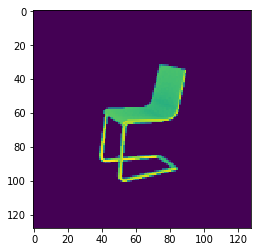

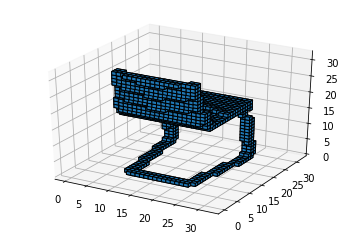

In [6]:
display_id = 56
batch_size = 5
train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id][0])
display3DObject(train_voxels[display_id])

In [7]:
class cnn1(nn.Module):
    def __init__(self, input_nc=1, ndf=10):
        super(cnn1, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
           torch.nn.ReLU()
        )
        
        self.reduce_dim_1 = torch.nn.Conv2d(ndf*4, 1,  kernel_size=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.reduce_dim_1(out)
        return out

In [8]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [9]:
class mvcnn(nn.Module):
    def __init__(self):
        super(mvcnn, self).__init__()
        self.view_pooling = torch.nn.Conv1d(12, 1,  kernel_size=1)
        self.cnn1 = cnn1()
        self.vae = VAE()
        
    def forward(self, x, number_of_views=12):
        # so x will be of the form [batch, number_of_views, c, h, w]
        x_views = torch.split(x, 1, dim=1)
        output_x = []
        for i in range(number_of_views):
            
            output = self.cnn1(x_views[i]).unsqueeze(dim=-1)
            output_x.append(output)
            
        #output is a list of len=number_of_views and shape [batch, c, h, w, 1] 
        output_x = torch.cat(output_x, dim=-1)
        #output is a list of len=number_of_views and shape [batch, c, h, w, number_of_views]
        #print(output_x.shape)
        n, c, w, h, v = output_x.size()
        output_x = output_x.view(n*c,w*h,v)
        m = nn.MaxPool1d(number_of_views, stride=1)
        pooled =  m(output_x)
        _, _, v = pooled.size()
        output_x = pooled.view(n, c, w, h)
        #print(output_x.shape)
        object_3d, mu, logvar = self.vae(output_x)
        #vae Part
        
        return object_3d, mu, logvar
        #output_x = self.view_pooling(output_x)
        #return output_x
        #Shape must be [batch, 1, 128, 128]
        
        

In [13]:
mvcn = mvcnn().cuda()
lr_vae = 0.003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
mvvae_solver = optim.Adam(mvcn.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [11]:
# for parameter in mvcn.parameters():
#     print(parameter)

In [34]:
#Training the mvcnn arch 
num_epochs = 500
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss(size_average=False)
for epoch in range(num_epochs):
    mvvae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float()
        generated_object, mu, logvar = mvcn(var_2D_data)
        generated_object= generated_object.squeeze()
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#         KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
#         KLD = torch.sum(KLD_element).mul_(-0.5)
        # https://arxiv.org/abs/1312.6114
        #print(logvar.shape)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #rint(KLD)
        loss_ = loss(generated_object, var_3D_data) + 10*KLD
        mvcn.zero_grad()
        loss_.backward()
        mvvae_solver.step()
        mvvae_losses.append(loss_)
        klds.append(KLD)
    val_3D_data = Variable(val_voxels).cuda().float()
    val_2D_data = Variable(val_images).cuda().float()
    generated_object_val, mu, sigma = mvcn(val_2D_data)
    generated_object_val = torch.round(generated_object_val.squeeze())
    accuracy = np.mean((generated_object_val  == val_3D_data).squeeze().data.cpu().numpy())
    mvvae_losses_mean = np.mean(np.concatenate(mvvae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "Mv VAE loss: ", mvvae_losses_mean.data.cpu().numpy()[0])
    print("Accuracy", accuracy, "KLD loss: ", kld_mean)

Epoch:  0 
 Mv VAE loss:  34064.707
Accuracy 0.78515625 KLD loss:  180.22752
Epoch:  1 
 Mv VAE loss:  33778.13
Accuracy 0.801593017578125 KLD loss:  180.63673
Epoch:  2 
 Mv VAE loss:  33718.785
Accuracy 0.8429473876953125 KLD loss:  186.97885
Epoch:  3 
 Mv VAE loss:  33087.605
Accuracy 0.837109375 KLD loss:  184.5292
Epoch:  4 
 Mv VAE loss:  33015.83
Accuracy 0.8389923095703125 KLD loss:  190.0396
Epoch:  5 
 Mv VAE loss:  32614.666
Accuracy 0.8351715087890625 KLD loss:  191.24268
Epoch:  6 
 Mv VAE loss:  32476.592
Accuracy 0.8240081787109375 KLD loss:  190.63274
Epoch:  7 
 Mv VAE loss:  32367.363
Accuracy 0.8418914794921875 KLD loss:  194.97462
Epoch:  8 
 Mv VAE loss:  32186.97
Accuracy 0.8393402099609375 KLD loss:  198.40364
Epoch:  9 
 Mv VAE loss:  31963.115
Accuracy 0.8366424560546875 KLD loss:  202.8166
Epoch:  10 
 Mv VAE loss:  31610.277
Accuracy 0.826678466796875 KLD loss:  202.30103
Epoch:  11 
 Mv VAE loss:  31443.812
Accuracy 0.815716552734375 KLD loss:  206.63945
Ep

Epoch:  98 
 Mv VAE loss:  20097.729
Accuracy 0.838079833984375 KLD loss:  284.76807
Epoch:  99 
 Mv VAE loss:  19909.586
Accuracy 0.8416412353515625 KLD loss:  285.00623
Epoch:  100 
 Mv VAE loss:  19915.174
Accuracy 0.84300537109375 KLD loss:  285.77432
Epoch:  101 
 Mv VAE loss:  19776.871
Accuracy 0.852850341796875 KLD loss:  285.76053
Epoch:  102 
 Mv VAE loss:  19670.832
Accuracy 0.8308929443359375 KLD loss:  285.05515
Epoch:  103 
 Mv VAE loss:  19662.613
Accuracy 0.838275146484375 KLD loss:  286.3194
Epoch:  104 
 Mv VAE loss:  19546.852
Accuracy 0.842559814453125 KLD loss:  287.1202
Epoch:  105 
 Mv VAE loss:  19510.256
Accuracy 0.8209930419921875 KLD loss:  290.3469
Epoch:  106 
 Mv VAE loss:  19571.074
Accuracy 0.829522705078125 KLD loss:  289.9235
Epoch:  107 
 Mv VAE loss:  19485.264
Accuracy 0.8281097412109375 KLD loss:  288.34076
Epoch:  108 
 Mv VAE loss:  19391.053
Accuracy 0.8311431884765625 KLD loss:  289.64517
Epoch:  109 
 Mv VAE loss:  19258.959
Accuracy 0.8415740

Epoch:  194 
 Mv VAE loss:  15578.911
Accuracy 0.8253204345703125 KLD loss:  306.93304
Epoch:  195 
 Mv VAE loss:  15523.236
Accuracy 0.8380126953125 KLD loss:  309.94812
Epoch:  196 
 Mv VAE loss:  15506.76
Accuracy 0.8495697021484375 KLD loss:  304.91324
Epoch:  197 
 Mv VAE loss:  15525.86
Accuracy 0.8323974609375 KLD loss:  307.72458
Epoch:  198 
 Mv VAE loss:  15427.982
Accuracy 0.83787841796875 KLD loss:  304.93472
Epoch:  199 
 Mv VAE loss:  15400.399
Accuracy 0.832757568359375 KLD loss:  307.2911
Epoch:  200 
 Mv VAE loss:  15387.083
Accuracy 0.8370574951171875 KLD loss:  305.75912
Epoch:  201 
 Mv VAE loss:  15381.385
Accuracy 0.835400390625 KLD loss:  308.5362
Epoch:  202 
 Mv VAE loss:  15322.623
Accuracy 0.8283721923828125 KLD loss:  307.04865
Epoch:  203 
 Mv VAE loss:  15342.444
Accuracy 0.841461181640625 KLD loss:  305.71375
Epoch:  204 
 Mv VAE loss:  15258.413
Accuracy 0.8387969970703125 KLD loss:  307.19543
Epoch:  205 
 Mv VAE loss:  15214.791
Accuracy 0.839651489257

Epoch:  290 
 Mv VAE loss:  13158.823
Accuracy 0.85001220703125 KLD loss:  306.81052
Epoch:  291 
 Mv VAE loss:  13094.88
Accuracy 0.8279022216796875 KLD loss:  308.29007
Epoch:  292 
 Mv VAE loss:  13193.618
Accuracy 0.8329193115234375 KLD loss:  311.33798
Epoch:  293 
 Mv VAE loss:  13142.223
Accuracy 0.8246307373046875 KLD loss:  308.9717
Epoch:  294 
 Mv VAE loss:  13072.912
Accuracy 0.834375 KLD loss:  308.6795
Epoch:  295 
 Mv VAE loss:  13095.942
Accuracy 0.8235076904296875 KLD loss:  307.8655
Epoch:  296 
 Mv VAE loss:  13073.875
Accuracy 0.8380401611328125 KLD loss:  309.6648
Epoch:  297 
 Mv VAE loss:  13063.427
Accuracy 0.831536865234375 KLD loss:  307.90686
Epoch:  298 
 Mv VAE loss:  13071.189
Accuracy 0.8402191162109375 KLD loss:  309.19507
Epoch:  299 
 Mv VAE loss:  13022.994
Accuracy 0.8284576416015625 KLD loss:  309.68527
Epoch:  300 
 Mv VAE loss:  12971.95
Accuracy 0.8257904052734375 KLD loss:  310.0989
Epoch:  301 
 Mv VAE loss:  12954.2
Accuracy 0.8409912109375 KL

Epoch:  386 
 Mv VAE loss:  11613.397
Accuracy 0.839007568359375 KLD loss:  306.44418
Epoch:  387 
 Mv VAE loss:  11524.025
Accuracy 0.837408447265625 KLD loss:  302.7985
Epoch:  388 
 Mv VAE loss:  11579.486
Accuracy 0.834710693359375 KLD loss:  304.3689
Epoch:  389 
 Mv VAE loss:  11572.167
Accuracy 0.84345703125 KLD loss:  307.22678
Epoch:  390 
 Mv VAE loss:  11564.739
Accuracy 0.8378936767578125 KLD loss:  304.25256
Epoch:  391 
 Mv VAE loss:  11556.161
Accuracy 0.83912353515625 KLD loss:  305.37427
Epoch:  392 
 Mv VAE loss:  11517.061
Accuracy 0.8365966796875 KLD loss:  303.66888
Epoch:  393 
 Mv VAE loss:  11537.243
Accuracy 0.839459228515625 KLD loss:  304.263
Epoch:  394 
 Mv VAE loss:  11555.079
Accuracy 0.8459228515625 KLD loss:  304.5651
Epoch:  395 
 Mv VAE loss:  11458.81
Accuracy 0.836968994140625 KLD loss:  305.89963
Epoch:  396 
 Mv VAE loss:  11460.767
Accuracy 0.8375457763671875 KLD loss:  302.77847
Epoch:  397 
 Mv VAE loss:  11472.31
Accuracy 0.8416473388671875 KL

KeyboardInterrupt: 

In [48]:
# #Testing the mvcnn architecture 

# mvcn = mvcnn().cuda()

#print(val_images[1:2])
i = 1
test_image = Variable(torch.FloatTensor(images[i:i+1])).cuda()
print(test_image[0][0:1].shape)
test_image = test_image[0][0:1].unsqueeze(1)
print(test_image.shape) 

test_object, _, _ = mvcn(test_image, number_of_views=1)


torch.Size([1, 128, 128])
torch.Size([1, 1, 128, 128])


Displaying the object


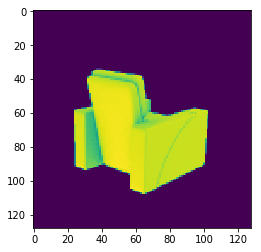

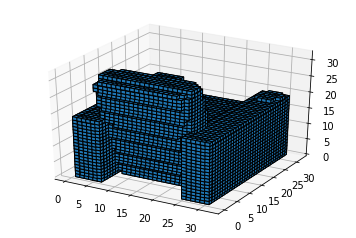

Displaying the object


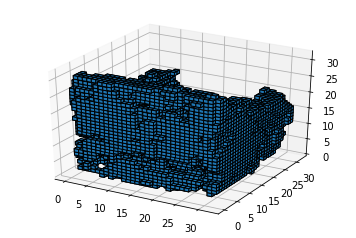

In [49]:

plt.imshow(images[i][0])
display3DObject(Variable(voxels[i]).data.cpu().numpy())
display3DObject(test_object.squeeze().data.cpu().numpy()>0.5)

In [ ]:
# print(value.shape)
# images = np.load('padded_gray_chair_imgs.npy')

In [ ]:
# images.shape

In [ ]:
# cnn1 = cnn1()

In [ ]:
# value = Variable(torch.FloatTensor(images[1])).view(-1,1,128,128)
# print(value.shape)
# cnn1(value)

In [ ]:
# lis = []
# value = Variable(torch.FloatTensor(images[1:4])).view(-1,1,128,128)
# print(value.shape)
# value1 = cnn1(value)
# lis.append(value1)
# value = Variable(torch.FloatTensor(images[1:4])).view(-1,1,128,128)
# print(value.shape)
# lis.append(cnn1(value))
# torch.cat(lis,1)